# Car Reservation Prediction

# Overview
Our goal is to predict the number of reservations of vehicles.

# Background
My math notebooks ([support vector machine](https://github.com/ginochen/ML_notes/blob/master/support_vector_machine.ipynb), [logistic regression](https://github.com/ginochen/ML_notes/blob/master/logistic_regression_cross_entropy.ipynb), [stochastic gradient descent](https://github.com/ginochen/ML_notes/blob/master/stochastic_gradient_descent.ipynb)) for the ML tools used in this project serve as reminders of what's really happening algorithmically in the python packages.

# Data 
Due to confidentiality issues of the data, let's import, clean and PCA transform the feature space. The PCA also serve as a normalizer which makes training converge faster for SVM.

In [1]:
# as before load all lib here
import pandas as pd
import numpy as np
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression # logistic regression function p(x) = 1/(1+e^{b^T*x}), logit(p) = b^T*x
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed,Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
df_vehicles = pd.read_csv('./vehicles.csv')
df_reservations = pd.read_csv('./reservations.csv')

In [3]:
#print('VEHICLES\n =============================================== \n',df_vehicles.head(4))
#print('\nRESERVATIONS\n ========================================== \n',df_reservations.head(4))

In [4]:
df = pd.merge(df_reservations,df_vehicles, how='inner', on='vehicle_id') # join on intersection on vehicle_id

In [5]:
print(df.iloc[0:5,2:])

   reservation_type  is_delivery  actual_price  recommended_price  num_images  \
0               2.0            0           121                 48           9   
1               2.0            0           121                 48           9   
2               2.0            1            61                 66          12   
3               2.0            1            61                 66          12   
4               1.0            1            61                 66          12   

   description_length  is_recent_model  
0                   0                0  
1                   0                0  
2                   0                0  
3                   0                0  
4                   0                0  


In [6]:
print('(samples, features) = %s'%str(df.shape))
print('max description length = %s'%str(df.description_length.max()))

(samples, features) = (195243, 9)
max description length = 7780


Let's checkout the feature space characteristics! We removed the "is_delivery" feature, since that's what we want to predict. Instead of using all 6 dim, which is hard to visualize, let's just look at the top 3 principle axes feature space:

In [7]:
nrows = df.shape[0]
df = df.dropna(axis=0) # drop NaNs
#x = df.iloc[:, [2,4,5,8]].values
x = df.iloc[0:nrows, [2,*range(4,9)]].values # skip is_delivery since it's the tag
y = df.iloc[0:nrows,3].values # is_delivery is the tag to color mark on projected features


Let's first look at how similar the two classes are using cosine similarity function:

In [33]:
def average_cosine_similarity(x,y,nsamp):
    '''
    x:  feature matrix [n_samples, n_features]
    y:  class vector   [n_samples]
    nsamp: number of samples to compute cosine similarity
    '''
    x1 = x[y==1,:] # class 1 feature data
    x0 = x[y==0,:] # class 0 feature data
    if nsamp>x1.shape[0] | nsamp>x0.shape[0]:
        nsamp = min(x1.shape[0],x0.shape[0])
        print('Use the lesser samples  = %s'%str(nsamp))
    cs01 = cosine_similarity(x1[:nsamp,:],x0[:nsamp,:]) # computes cosine simlilarity between all pairwise samples in x1 and x0
    plt.hist(cs01.reshape(-1,1),100); plt.show()
    
    print('The average cosine similarity = %s'%str(np.mean(cs01.reshape(-1,1))))
    print('The median cosine similarity = %s'%str(np.median(cs01.reshape(-1,1))))

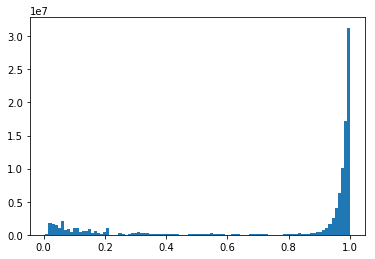

The average cosine similarity = 0.794856595919178
The median cosine similarity = 0.9789127419404964


In [42]:
average_cosine_similarity(x,y,10000)

The average cosine similarity between class 0 and class 1 are very high, meaning they are inseparable in feature space.

Let's see if doing PCA transform can help separate the two sample classes:

In [14]:
pca = PCA(n_components=x.shape[1]) # use all 
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
s = pca.singular_values_
print(s)  # just the eigenvalues of the PC direction vectors, also the stdev of the PCs

[2.35818460e+05 3.15943855e+04 7.78928641e+03 2.22170080e+03
 2.13971098e+02 2.02733204e+02]


In [16]:
print(pca.explained_variance_ratio_) # ([i/sum(pca.singular_values_**2) for i in pca.singular_values_**2])

[9.81227787e-01 1.76130297e-02 1.07055649e-03 8.70934277e-05
 8.07838364e-07 7.25210377e-07]


The sigular values are just the PC stdev of the PC axes, and the explained variance are just the component variances (i.e., squared stdev) divide by the total variance. 

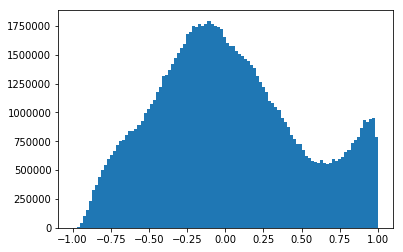

The average cosine similarity = 0.01809103653476206
The median cosine similarity = -0.029494732850648644


In [43]:
P = pca.transform(x) # the projection of all samples on all PC axes, 
PC_normal = np.asarray([P[:,i]/s[i] for i in range(len(s))]).T # normalized PC: PC divided by sigular values
# we can use P = PCA(n_components=2).transform(x)  if we just want the projections on the first 2 components, 
# this gives the same values as the full transformation, but just trancated 
average_cosine_similarity(PC_normal,y,10000) # computes cosine simlilarity between all pairwise samples in x1 and x0

The mean and median consine similarity are very low, which shows that the two classes in PCA feature space are probably more separated.

Let's see how the projection behaves on the three leading modes in a plot:

Samples: Class 0 (red) = 51295, Class 1 (blue) = 142593


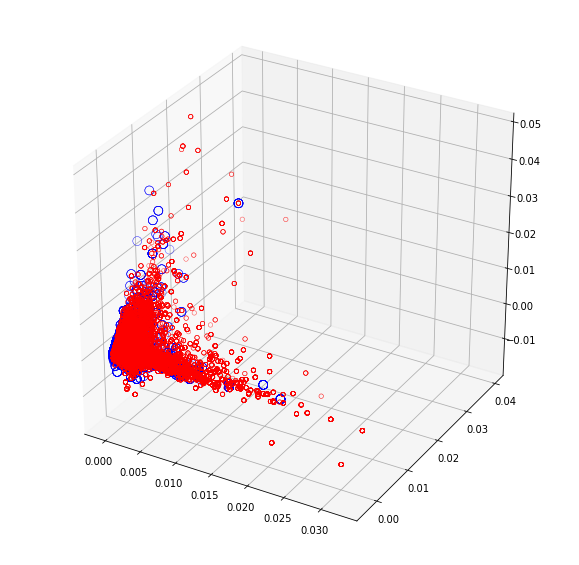

In [45]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
print("Samples: Class 0 (red) = %s, Class 1 (blue) = %s"%(sum(y==0),sum(y==1)))
ax.scatter(PC_normal[y==1,0], PC_normal[y==1,1], PC_normal[y==1,2], edgecolors='r', s=20, facecolors='none', linewidths=0.5, label='Class 1')
ax.scatter(PC_normal[y==0,0], PC_normal[y==0,1], PC_normal[y==0,2], edgecolors='b', s=80, facecolors='none', linewidths=0.5, label='Class 0')
plt.show()

Seems like the two classes are separated (except some outliers) in the PCA feature space with Class 0 (blue) more clustered and Class 1 (red) more scattered. This seems like we can do a "kernel trick" by transforming the data by the "closeness" to the data centroid. 

Since rescaling is recommended for reasons such as making feature space more "spherical" instead of "elliptical" to speed up the stochastic gradient descent. Therefore we will just work on the normalized PC to avoid using `sklearn.preprocessing` to rescale the data.

We are going to look at logistic regression, SVM, XGBoost and move forward to DNN later.


Let's split the data into 80% training, 10% validation and 10% testing:

In [46]:
ntotal = PC_normal.shape[0]
ntrain = round(0.8*ntotal)
nvalid = round(0.9*ntotal)
np.random.shuffle(PC_normal) # shuffle along the first axis to de-order the samples
#scaler = preprocessing.StandardScaler().fit(x) # standard normal z-scaling
#xz = scaler.transform(x) # z-scaling
#x_train,x_valid,x_test = x[:ntrain,:], x[ntrain:nvalid,:], x[nvalid:,:] # no scaling
#x_train,x_valid,x_test = xz[:ntrain,:], xz[ntrain:nvalid,:], xz[nvalid:,:] # z scaling
x_train,x_valid,x_test = PC_normal[:ntrain,:3], PC_normal[ntrain:nvalid,:3], PC_normal[nvalid:,:3] # PCA scaling
y_train,y_valid,y_test = y[:ntrain], y[ntrain:nvalid], y[nvalid:]

In [47]:
print(ntotal,x_train.shape,x_valid.shape,x_test.shape)

193888 (155110, 3) (19389, 3) (19389, 3)


# Train Models
### Logistict Regression
Let's start with logistic regression:

In [48]:
logreg = LogisticRegression(C=1e5, solver='lbfgs').fit(x_train,y_train) # multinomial uses cross entropy 
y_pred_lr = logreg.predict(x_test)
y_predp_lr = logreg.predict_proba(x_test)
report = classification_report(y_test,y_pred_lr,target_names=['class 0','class 1'])
# X = [n_samples, n_features], y = [n_samples]
# C = Inverse of regularization strength; must be a positive float. 
#     Like in support vector machines, smaller values specify stronger regularization.
# solver = 'sag': stochastic average gradient descent
#        = 'lbfgs': some Newton method
print('first two actual classes = %s'%str(y_test[:2]))
print('first two predicted classes = %s'%str(logreg.predict(x_test[:2,:]))) # predict class vs real class
print('first two predicted probalities [0 vs 1] = %s'%str(logreg.predict_proba(x_test[:2,:]))) # predict
# print('score = %s'%str(logreg.score(x_test,y_test))) # Score is the ratio of correctly predicted (TP+TN) samples.
print(report) # support is just the # of samples detected or used

first two actual classes = [1 1]
first two predicted classes = [1 1]
first two predicted probalities [0 vs 1] = [[0.26305848 0.73694152]
 [0.26305847 0.73694153]]
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      5150
     class 1       0.73      1.00      0.85     14239

   micro avg       0.73      0.73      0.73     19389
   macro avg       0.37      0.50      0.42     19389
weighted avg       0.54      0.73      0.62     19389



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SVM
SVM with kernel computes the distance between every training points which is super expensive O($n_\text{features} \times n_\text{observations}^2$), so reduce the training samples to <100000, and don't do parameter grid search:

In [49]:
 clf = SVC(gamma='auto') # For non-linear classification use 
                        # gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. 
                        # Default is set to 'rbf' which is Radial Basis Function kernel
clf.fit(x_train[:50000,:], y_train[:50000])            
# let's do a grid search over the C and Gamma parameter space, 
# C (=1/\lambda) is a regularization scale , larger (smaller) C gives lower (higher) bias and higher (lower) variance
# Gamma (=1/\sigma) is a scale on kernel "width/variance", larger (smaller) Gamma gives lower (higher) bias and higher (lower) variance
# go to https://github.com/ginochen/ML_notes to learn more about these two parameters   
# The kernel trick is super expensive since it computes distance between each point!!
# see solution https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution
#C_range = np.logspace(-2, 10, 3) # linear spaced between log10scale -2 to 10, and returns 10 based exponents of 10^-2, ...1
#gamma_range = np.logspace(-9, 3, 3) 
#param_grid = dict(gamma=gamma_range, C=C_range) 
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
#grid.fit(x_train, y_train)

#print("The best parameters are %s with a score of %0.2f"
#      % (grid.best_params_, grid.best_score_))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [50]:
y_pred_svc = clf.predict(x_test)
print(x_test.shape,y_pred_svc.shape,sum(y_pred_svc))

(19389, 3) (19389,) 19389


In [51]:
print(classification_report(y_test,y_pred_svc,target_names=['class 0','class 1']))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      5150
     class 1       0.73      1.00      0.85     14239

   micro avg       0.73      0.73      0.73     19389
   macro avg       0.37      0.50      0.42     19389
weighted avg       0.54      0.73      0.62     19389



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### DNN

In [52]:
class KerasBatchGenerator:
    def __init__(self,data,batchsize,ndim,nsteps,skip_steps):
        self.data=data
        self.batchsize=batchsize
        self.current_idx=0
        self.nsteps=nsteps
        self.skip_steps = skip_steps
        self.ndim = ndim
    def generate(self,model):
        x = np.zeros((self.nsteps, self.ndim))            
        y = np.zeros((self.nsteps, 1))
        while True:
            for i in range(self.batchsize):
                x, y = self.data[self.current_idx:self.current_idx+self.nsteps,:-1], self.data[self.current_idx:self.current_idx+self.nsteps,-1]
                self.current_idx += self.skip_steps             
                yield x, y # yield returns a set of x,y values for model.fit_generator to perform batch training

In [ ]:
# Define model parameters
batchsize = 100 # number of mini-batches per epoch
nsteps = 32 # number of samples in each mini-batch
ndim = x_train.shape[1]  # feature dimensions
hdim = 100 # hidden layer dimensions
hlayers= 50 # hidden layers
nepochs=50
dropoutRate = 0.5
ntrain = x_train.shape[0]
nvalid = x_valid.shape[0]
datapath = './'
train_data_generator = KerasBatchGenerator(np.concatenate((x_train,y_train.reshape(-1,1)),axis=1), batchsize, ndim, nsteps, skip_steps=nsteps)
valid_data_generator = KerasBatchGenerator(np.concatenate((x_valid,y_valid.reshape(-1,1)),axis=1), batchsize, ndim, nsteps, skip_steps=nsteps)
def build_model(ndim,hdim,hlayers,dropoutRate, datapath):
    model = Sequential()
    model.add(Dense(ndim, input_dim= ndim, kernel_initializer='glorot_normal', activation='relu'))
    for _ in range(hlayers-1):
        model.add(Dropout(dropoutRate))
        model.add(Dense(hdim, kernel_initializer='glorot_normal', activation='relu')) 
    model.add(Dense(1,kernel_initializer='glorot_normal', activation='sigmoid')) # determine the probability of anomaly 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
#    checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model-{epoch:02d}.hdf5', verbose=1)
    checkpointer = [EarlyStopping(monitor='val_loss', patience=10), # patience: wait for at least 5 epochs before early stopping
       ModelCheckpoint(filepath=datapath+'/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)]
    model.summary()
    return model, checkpointer
last_epoch = 0 # set to 0 for new model training
model, checkpointer  = build_model(ndim, hdim, hlayers, dropoutRate, datapath)
model.fit_generator(train_data_generator.generate(model), ntrain//(batchsize*nsteps), epochs=last_epoch+nepochs,
                validation_data=valid_data_generator.generate(model), validation_steps=math.ceil(nvalid/(batchsize*nsteps)),
                callbacks=checkpointer,shuffle=True,initial_epoch=last_epoch,verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
__________

In [212]:
def predict(prediction_samp,data):
    model = keras.models.load_model('./best_model.h5')
    y=[None]*prediction_samp
    for i in range(prediction_samp):
        y[i] = model.predict(data[i,:].reshape(-1,1))
    return y

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
prediction_samp=10000
y_preddnn = np.asarray(predict(prediction_samp,x_test)).reshape(-1,1)
y_true_dnn = y_test[:prediction_samp].reshape(-1,1)

In [214]:
y_pred_dnn = y_preddnn>=0.5
print(classification_report(y_true_dnn,y_pred_dnn,target_names=['class 0','class 1']))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      2445
     class 1       0.76      1.00      0.86      7555

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.38      0.50      0.43     10000
weighted avg       0.57      0.76      0.65     10000



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Reference
* [Endless run of kernel SVM](https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution)
* [mathematical formulation of SVC](https://scikit-learn.org/stable/modules/svm.html)